# Examples of autoGDC with Adenomas

#### The autoGDC package is a wrapper for the gdc-client downloader, as well as a tool to aggregate and analyze data

While common values for `cases.disease_type` in the GDC are: 
```python
    common_disease_types = [
      "Gliomas",
      'Adenomas and Adenocarcinomas',
      "Epithelial Neoplasms, NOS",
      "Ductal and Lobular Neoplasms",
      "Squamous Cell Neoplasms",
      "Cystic, Mucinous and Serous Neoplasms",
      "Neuroblastoma"
    ]
```
Here, we will simply be using `Adenomas and Adenocarcinomas`.

Similarly, while several different biological assays / microchips / or workflows are available:
```python
    common_workflows = [
      "HTSeq - Counts",
      "HTSeq - FPKM",
      "HTSeq - FPKM-UQ",
      "Liftover",
      "BCGSC miRNA Profiling"
    ]
```

We will be restricting our analyses to containing only count data and DNA methylation.

Furthermore, we will test the differences of tissue between normal tissue and primary glioma tissue
(the GDC has a lack of healthy control patients) with the addition of the `cases.sample_type` field.
```python
    common_sample_types = [
      "primary tumor",
      "metastatic",
      "blood derived normal",
      "solid tissue normal"
    ]
```

## First load the data for all examples

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

sns.set_style("whitegrid")

%load_ext autoreload

In [12]:
# from autoGDC.app import Dataset

# # This is the type of format that the gdc-client accepts
# #   To discover new combinations easily, try the advanced search on GDC
# #   https://portal.gdc.cancer.gov/query
# filt = {
#     "op":'and',
#         "content":[
#             {"op":"IN",
#                 "content":{
#                     "field": 'cases.disease_type',
#                     "value": ["Adenomas and Adenocarcinomas"]}},
#             {"op":"IN",
#                 "content":{
#                     "field": 'files.analysis.workflow_type',
#                     "value": ["HTSeq - Counts",
#                               "Liftover"]}},
#             {"op":"IN",
#                 "content":{
#                     "field": "cases.samples.sample_type",
#                     "value":  ["primary tumor",
#                                "solid tissue normal"]}}
#         ]
# }

# # Main Study Oject
# study = Dataset(config_key = "default",
#                 filt = filt,
#                 size = 5000,
#                 contrasts = ["sample_type"],
#                 paired_assay = True)

[ Future queries will be cached in "/home/chaxor/release_testing/autoGDC/autoGDC/data/mygene/mygene.sqlite.sqlite" ]


# Alternative method!

In [31]:
from autoGDC.app import Dataset

# Main Study Oject
study = Dataset(config_key = "default",
                contrasts = ["sample_type"],
                paired_assay = True)
m = study.archive.metadatabase
sample_type_mask = m.sample_type.isin(["Primary Tumor", "Solid Tissue Normal"])
workflow_type_mask = m.workflow_type.isin(["HTSeq - Counts", "Liftover"])
disease_type_mask = m.disease_type.isin(["Adenomas and Adenocarcinomas"])
study.metadata = m[disease_type_mask & workflow_type_mask & sample_type_mask].dropna(how = "all", axis = 1)

[ Future queries will be cached in "/home/chaxor/release_testing/autoGDC/autoGDC/data/mygene/mygene.sqlite.sqlite" ]


/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Now we can subset further and pair DNAm and RNA

In [34]:
# Paired `primary tumor` and `solid tissue normal` cases
cases = study.metadata.groupby("case_id")["sample_type"]\
                      .apply(lambda x: len(pd.Series(x).unique())>1)

study.metadata = study.metadata[study.metadata["case_id"].isin(cases[cases].index.tolist())]

# Paired cases `HTSeq FPKM` and `Liftover` *WITHIN* the tissue type
cases = study.metadata.groupby(["case_id", "sample_type"])["workflow_type"]\
                      .apply(lambda x: len(pd.Series(x).unique())>1)\
                      .unstack().sum(axis=1)>1
study.metadata = study.metadata[study.metadata["case_id"].isin(cases[cases].index.tolist())]
display(study.metadata.head(3))
print("Number of files:", study.metadata.shape[0])

filename  \
id                                                                                        
2b5c9b5c-41ca-4409-9865-8132cdd1221a  d7c21711-bd24-4d39-8a16-2c33080e51f8.htseq.cou...   
6e3da48e-ef62-43bc-ae75-2a58ad25392a  d5607680-758b-4ee5-ae0f-a61f7c3133c1.htseq.cou...   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3  58957ce0-4efa-4194-a3e6-37984ac010c7.htseq.cou...   

                                                                   md5  \
id                                                                       
2b5c9b5c-41ca-4409-9865-8132cdd1221a  dc80f3c7d0c6f51b19bb3ee94e674055   
6e3da48e-ef62-43bc-ae75-2a58ad25392a  7502b334a207080b2b2aacc62d7ffedd   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3  7447e07d3a6cbc1b9822fe03e37af692   

                                        size     state        acl project_id  \
id                                                                             
2b5c9b5c-41ca-4409-9865-8132cdd1221a  241382  released  [b'open']  TCGA-LIHC   
6e3da48e-ef62-43bc-ae75-2a58ad25392a  247393  released  [b'open']  TCGA-COAD   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3  246984  released  [b'open']  TCGA-LIHC   

                                       category            data_category  \
id                                                                         
2b5c9b5c-41ca-4409-9865-8132cdd1221a  data_file  Transcriptome Profiling   
6e3da48e-ef62-43bc-ae75-2a58ad25392a  data_file  Transcriptome Profiling   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3  data_file  Transcriptome Profiling   

                                                                   file_id  \
id                                                                           
2b5c9b5c-41ca-4409-9865-8132cdd1221a  2b5c9b5c-41ca-4409-9865-8132cdd1221a   
6e3da48e-ef62-43bc-ae75-2a58ad25392a  6e3da48e-ef62-43bc-ae75-2a58ad25392a   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3  1c2ca1c5-e3c7-4816-94ca-e5142794ffb3   

                                      file_size  ... risk_factor bmi  \
id                                               ...                   
2b5c9b5c-41ca-4409-9865-8132cdd1221a   241382.0  ...         NaN NaN   
6e3da48e-ef62-43bc-ae75-2a58ad25392a   247393.0  ...         NaN NaN   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3   246984.0  ...         NaN NaN   

                                       workflow_type          sample_type  \
id                                                                          
2b5c9b5c-41ca-4409-9865-8132cdd1221a  HTSeq - Counts        Primary Tumor   
6e3da48e-ef62-43bc-ae75-2a58ad25392a  HTSeq - Counts        Primary Tumor   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3  HTSeq - Counts  Solid Tissue Normal   

                                     tissue_type  \
id                                                 
2b5c9b5c-41ca-4409-9865-8132cdd1221a         NaN   
6e3da48e-ef62-43bc-ae75-2a58ad25392a         NaN   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3         NaN   

                                                                 sample_id  \
id                                                                           
2b5c9b5c-41ca-4409-9865-8132cdd1221a  9b68c72d-30d4-4a7a-ade7-a2bde50a84f2   
6e3da48e-ef62-43bc-ae75-2a58ad25392a  e86137c5-37af-4a47-8f29-5a947e013536   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3  d746f333-a5dd-4464-a091-84e9cf9665b8   

                                     tumor_descriptor  \
id                                                      
2b5c9b5c-41ca-4409-9865-8132cdd1221a              NaN   
6e3da48e-ef62-43bc-ae75-2a58ad25392a              NaN   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3              NaN   

                                                                aliquot_id  \
id                                                                           
2b5c9b5c-41ca-4409-9865-8132cdd1221a  e5e12896-2cf3-4d5d-8f79-00cd964fc132   
6e3da48e-ef62-43bc-ae75-2a58ad25392a  be646d0d-d5a6-478b-a3eb-71142d84c884   
1c2ca1c5-e3c7-4816-94ca-e5142794ffb3  608bf540-a094-441e-9329-9e759ff5d84d   

   

Number of files: 1052


### Filter to cases having both DNAm and RNA data within both normal and tumor tissue

In [4]:
# Paired `primary tumor` and `solid tissue normal` cases
cases = study.metadata.groupby("case_id")["sample_type"]\
                      .apply(lambda x: len(pd.Series(x).unique())>1)
study.metadata = study.metadata[study.metadata["case_id"].isin(cases[cases].index.tolist())]

# Paired cases `HTSeq FPKM` and `Liftover` *WITHIN* the tissue type
cases = study.metadata.groupby(["case_id", "sample_type"])["workflow_type"]\
                      .apply(lambda x: len(pd.Series(x).unique())>1)\
                      .unstack().sum(axis=1)>1
study.metadata = study.metadata[study.metadata["case_id"].isin(cases[cases].index.tolist())]
display(study.metadata.head(3))
print("Number of files:", study.metadata.shape[0])

INFO:autoGDC.autoGDC:Searching for data that meets criteria...
INFO:autoGDC.autoGDC:Found 2425 files which match the criteria.


access workflow_type  \
id                                                          
770c5196-5b1c-414a-92f8-c502b8365d1b   open      Liftover   
165886b2-c70d-4cc6-8e6f-00d6a6c06602   open      Liftover   
924fe465-fc00-419e-8c9d-f7c842704f78   open      Liftover   

                                                                   case_id  \
id                                                                           
770c5196-5b1c-414a-92f8-c502b8365d1b  64bf32c9-9466-404a-a147-e7a0b9e91e34   
165886b2-c70d-4cc6-8e6f-00d6a6c06602  e90ab72a-4bbb-4c37-b48a-8a1a85d79d04   
924fe465-fc00-419e-8c9d-f7c842704f78  9c7875ad-ab71-4d48-b2e3-e4c7a46393e9   

                                      age_at_diagnosis    sample_type  \
id                                                                      
770c5196-5b1c-414a-92f8-c502b8365d1b           24249.0  Primary Tumor   
165886b2-c70d-4cc6-8e6f-00d6a6c06602           22475.0  Primary Tumor   
924fe465-fc00-419e-8c9d-f7c842704f78           30133.0  Primary Tumor   

                                                                              file_name  \
id                                                                                        
770c5196-5b1c-414a-92f8-c502b8365d1b  jhu-usc.edu_PRAD.HumanMethylation450.3.lvl-3.T...   
165886b2-c70d-4cc6-8e6f-00d6a6c06602  jhu-usc.edu_PRAD.HumanMethylation450.4.lvl-3.T...   
924fe465-fc00-419e-8c9d-f7c842704f78  jhu-usc.edu_LUAD.HumanMethylation450.4.lvl-3.T...   

                                      file_size  \
id                                                
770c5196-5b1c-414a-92f8-c502b8365d1b  141282109   
165886b2-c70d-4cc6-8e6f-00d6a6c06602  141288281   
924fe465-fc00-419e-8c9d-f7c842704f78  141252265   

                                                                md5sum  \
id                                                                       
770c5196-5b1c-414a-92f8-c502b8365d1b  b9b8315fac92043c7c475b3a1e12248f   
165886b2-c70d-4cc6-8e6f-00d6a6c06602  2506a7e6190c3fef07c3d045f64df4a8   
924fe465-fc00-419e-8c9d-f7c842704f78  3a43ebfe9fb75a8429b07a7864be10dd   

                                                                         submitter_id  \
id                                                                                      
770c5196-5b1c-414a-92f8-c502b8365d1b  f43c0b03-fdc9-41db-acfa-6565e5035818-beta-value   
165886b2-c70d-4cc6-8e6f-00d6a6c06602  4678a2ce-937c-42a1-b9a6-e896a8b98cc5-beta-value   
924fe465-fc00-419e-8c9d-f7c842704f78  eb070dcd-907d-421a-ba11-bbaa31e1f8f2-beta-value   

                                            age  
id                                               
770c5196-5b1c-414a-92f8-c502b8365d1b  66.435616  
165886b2-c70d-4cc6-8e6f-00d6a6c06602  61.575342  
924fe465-fc00-419e-8c9d-f7c842704f78  82.556164

Number of files: 86


### Overview of the patient/sample metadata

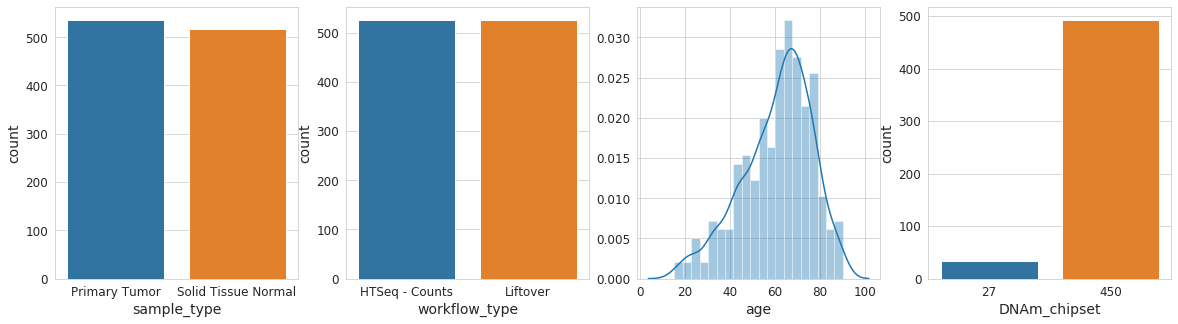

In [35]:
fig, axs = plt.subplots(ncols=4)
# Make sure the Tissue types are balanced
sns.countplot(study.metadata.sample_type, ax=axs[0])

# Make sure the two biological assays are balanced
sns.countplot(study.metadata.workflow_type, ax=axs[1]);

# Distribution of ages
sns.distplot(study.metadata.age.dropna(), ax=axs[2])

# DNA methylation has two different microarray chipsets
#   450k and 27k
dnameth = study.metadata[study.metadata.workflow_type=="Liftover"]
dnameth = dnameth.assign(DNAm_chipset=dnameth.file_name.apply(lambda x: "450" if "450" in x else "27"))
sns.countplot(dnameth["DNAm_chipset"], ax=axs[3])
plt.show()

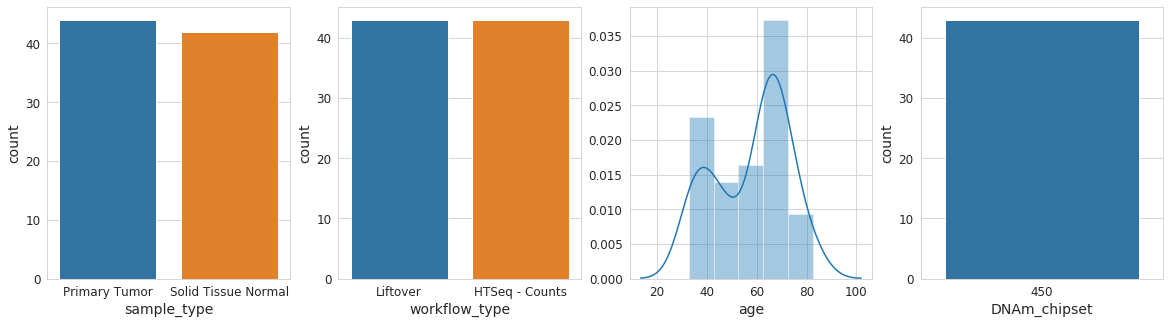

In [5]:
fig, axs = plt.subplots(ncols=4)
# Make sure the Tissue types are balanced
sns.countplot(study.metadata.sample_type, ax=axs[0])

# Make sure the two biological assays are balanced
sns.countplot(study.metadata.workflow_type, ax=axs[1]);

# Distribution of ages
sns.distplot(study.metadata.age.dropna(), ax=axs[2])

# DNA methylation has two different microarray chipsets
#   450k and 27k
dnameth = study.metadata[study.metadata.workflow_type=="Liftover"]
dnameth = dnameth.assign(DNAm_chipset=dnameth.file_name.apply(lambda x: "450" if "450" in x else "27"))
sns.countplot(dnameth["DNAm_chipset"], ax=axs[3])
plt.show()

## **Example 1**: 
## **Differential Gene Expression**
The `study.data` dictionary holds several different biological assay dataframes, which can be used for DEG analysis.
We are intered in the transcriptome (counts) data for differential expression.

In [36]:
df = study.data["RNA_counts"]
df.head()

AttributeError: 'Archive' object has no attribute '_owned_file_ids'

In [6]:
df = study.data["Transcriptome Profiling"]["counts"]
df.head()

INFO:autoGDC.autoGDC:Downloading these file_ids:set()
INFO:autoGDC.autoGDC:Creating dataframes...
INFO:autoGDC.autoGDC:HumanMethylation450 DataFrame...
INFO:autoGDC.autoGDC:HumanMethylation27 DataFrame...
INFO:autoGDC.autoGDC:FPKM_txt DataFrame...
INFO:autoGDC.autoGDC:FPKM-UQ DataFrame...
INFO:autoGDC.autoGDC:htseq_counts_gz DataFrame...
INFO:autoGDC.autoGDC:mirnas_quantification DataFrame...
INFO:autoGDC.autoGDC:isoforms_quantification DataFrame...
INFO:autoGDC.autoGDC:Finished constructing data structure...


file_id   048b4777-a420-4b0a-b88a-57456746b526  \
0                                                
TSPAN6                             3286.744186   
TNMD                                  6.441860   
DPM1                               1533.860465   
SCYL3                              1553.534884   
C1orf112                            571.906977   

file_id   26748992-7910-4a84-bfbd-9dbd7c28145a  \
0                                                
TSPAN6                             3853.279070   
TNMD                                 10.162791   
DPM1                               2827.162791   
SCYL3                              1067.023256   
C1orf112                            240.906977   

file_id   3e6f8b24-a47e-48e2-be5c-77e27272a92f  \
0                                                
TSPAN6                             2985.651163   
TNMD                                 44.790698   
DPM1                               1323.837209   
SCYL3                               996.837209   
C1orf112                            357.441860   

file_id   43318e69-4aa1-4f76-ba79-658a3a04fe87  \
0                                                
TSPAN6                             3415.046512   
TNMD                                 10.581395   
DPM1                               1665.209302   
SCYL3                               928.232558   
C1orf112                            701.139535   

file_id   4c47728b-7ef8-4eed-a64a-50059544e655  \
0                                                
TSPAN6                             5779.604651   
TNMD                                 87.837209   
DPM1                               1756.488372   
SCYL3                              1688.906977   
C1orf112                            454.139535   

file_id   5f9c9781-cce9-4cc3-af83-098c1425e717  \
0                                                
TSPAN6                             5470.976744   
TNMD                                 49.813953   
DPM1                               2568.069767   
SCYL3                              1268.139535   
C1orf112                            589.720930   

file_id   78352f8b-219b-431a-b536-cda97ef842b4  \
0                                                
TSPAN6                             2936.860465   
TNMD                                 17.930233   
DPM1                               1944.906977   
SCYL3                              1023.116279   
C1orf112                            297.651163   

file_id   78413072-0fbb-40ed-b01a-2f0ae9b24dd0  \
0                                                
TSPAN6                             4567.395349   
TNMD                                 93.441860   
DPM1                               1472.139535   
SCYL3                              1287.046512   
C1orf112                            364.860465   

file_id   7a9d8fe3-0ddb-467a-941d-dae8909c5658  \
0                                                
TSPAN6                             4110.395349   
TNMD                                 59.093023   
DPM1                               1774.325581   
SCYL3                              1181.255814   
C1orf112                            363.674419   

file_id   84399bcb-f018-48db-b678-67d3573c174d  ...  \
0                                               ...   
TSPAN6                             4243.209302  ...   
TNMD                                  5.697674  ...   
DPM1                               1891.953488  ...   
SCYL3                              1098.558140  ...   
C1orf112                            464.000000  ...   

file_id   eb41cdf0-d438-43a4-b08b-f88250c53bd1  \
0                                                
TSPAN6                             5700.279070   
TNMD                                 67.604651   
DPM1                               1494.860465   
SCYL3                              1133.674419   
C1orf112                            555.720930   

file_id   eb59b97e-effe-40c6-a582-7bea00a42d83  \
0                                                
TSPA

### The Differential Gene list
The autoGDC package has a simple interface to DEG analysis via `study.ddx()`, which calls the `DESeq2` package in R, making the process of DEG analysis simple

In [7]:
DEG = study.ddx()

/home/chaxor/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


### Cluster map of differential genes

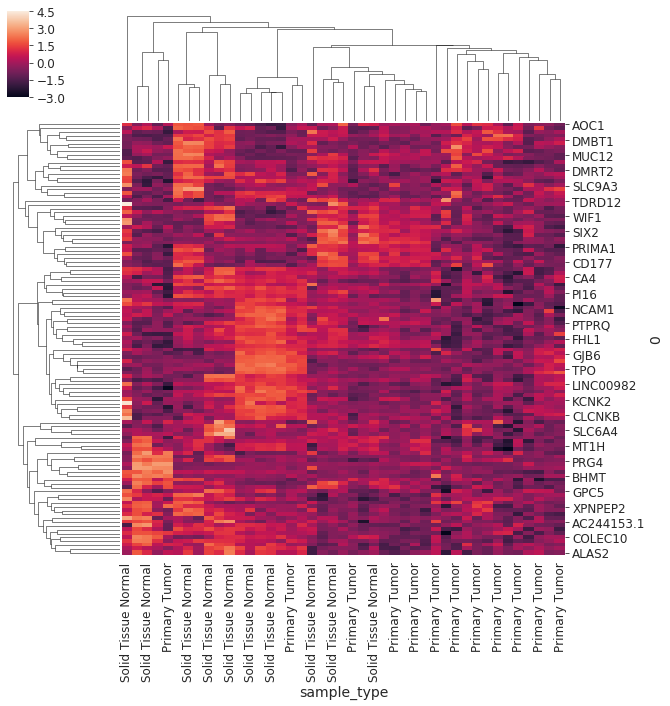

In [19]:
from scipy.stats import zscore
import numpy as np

plot_df = df.loc[DEG.index.tolist(), ]
plot_df = pd.DataFrame(zscore(np.log(plot_df+1).T).T,
                       index=plot_df.index,
                       columns=study.metadata.loc[plot_df.columns].sample_type)
sns.clustermap(plot_df)
plt.show()

### Enrichment Analysis

In [31]:
import gseapy

g = gseapy.enrichr(gene_list = DEG.index.tolist(),
                   description = 'pathway',
                   gene_sets = 'GO_Biological_Process_2018',
                   outdir = 'test',
                   cutoff = 0.05)
g.results[g.results["Adjusted P-value"]<0.05]

INFO:gseapy:Connecting to Enrichr Server to get latest library names
INFO:gseapy:Analysis name: pathway, Enrichr Library: GO_Biological_Process_2018
INFO:gseapy:Save file of enrichment results: Job Id:204e738f484b01e5a50f9ceae7d78579
INFO:gseapy:Done.



Gene_set  \
0   GO_Biological_Process_2018   
1   GO_Biological_Process_2018   
2   GO_Biological_Process_2018   
3   GO_Biological_Process_2018   
4   GO_Biological_Process_2018   
5   GO_Biological_Process_2018   
6   GO_Biological_Process_2018   
7   GO_Biological_Process_2018   
8   GO_Biological_Process_2018   
9   GO_Biological_Process_2018   
10  GO_Biological_Process_2018   
11  GO_Biological_Process_2018   
12  GO_Biological_Process_2018   
13  GO_Biological_Process_2018   
14  GO_Biological_Process_2018   
15  GO_Biological_Process_2018   
16  GO_Biological_Process_2018   

                                                 Term Overlap       P-value  \
0        cellular response to copper ion (GO:0071280)    5/21  9.969362e-08   
1                  bicarbonate transport (GO:0015701)    6/41  1.088919e-07   
2                 response to copper ion (GO:0046688)    5/25  2.556497e-07   
3                          ion transport (GO:0006811)  10/289  5.689523e-06   
4                organic anion transport (GO:0015711)   7/124  6.657093e-06   
5   monovalent inorganic cation homeostasis (GO:00...    4/26  1.312026e-05   
6   cellular transition metal ion homeostasis (GO:...    6/93  1.454700e-05   
7                       regulation of pH (GO:0006885)    3/10  2.047351e-05   
8          cellular zinc ion homeostasis (GO:0006882)    4/31  2.701933e-05   
9                   zinc ion homeostasis (GO:0055069)    4/31  2.701933e-05   
10                  response to zinc ion (GO:0010043)    4/32  3.074514e-05   
11             regulation of cellular pH (GO:0030641)    4/38  6.148455e-05   
12         receptor-mediated endocytosis (GO:0006898)   7/188  9.675513e-05   
13        regulation of intracellular pH (GO:0051453)    4/44  1.101637e-04   
14                           endocytosis (GO:0006897)   8/263  1.251234e-04   
15  inorganic cation transmembrane transport (GO:0...   6/140  1.444525e-04   
16         cellular response to zinc ion (GO:0071294)    3/19  1.593039e-04   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.000509            0                     0   42.140750   
1           0.000278            0                     0   25.901144   
2           0.000435            0                     0   35.398230   
3           0.007258            0                     0    6.124261   
4           0.006794            0                     0    9.991436   
5           0.011159            0                     0   27.229408   
6           0.010605            0                     0   11.418784   
7           0.013060            0                     0   53.097345   
8           0.015320            0                     0   22.837568   
9           0.013788            0                     0   22.837568   
10          0.014263            0                     0   22.123894   
11          0.026146            0                     0   18.630647   
12          0.037980            0                     0    6.590096   
13          0.040155            0                     0   16.090105   
14          0.042567            0                     0    5.383761   
15          0.046071            0                     0    7.585335   
16          0.047819            0                     0   27.945971   

    Combined Score                                              Genes  
0       679.357949                           AOC1;MT1M;MT1G;MT1H;AQP2  
1       415.270703                    CA2;CA4;CA7;HBB;SLC26A7;SLC26A4  
2       537.325937                           AOC1;MT1M;MT1G;MT1H;AQP2  
3        73.961994  SLC9A3;SCNN1B;CLCNKB;SLC26A7;CLCNKA;ATP6V0A4;A...  
4       119.096194                CA2;ALB;CA4;CA7;SLC26A7;HBB;SLC26A4  
5       306.095387                   SCNN1B;ATP6V0A4;SLC26A4;ATP6V1B1  
6       127.183848                ALAS2;SLC30A8;SCARA5;MT1M;MT1G;MT1H  
7       573.259048                          ATP6V0A4;SLC26A4;ATP6V1B1  
8       240.227416                             SLC30A8;MT1M

---

## **Example 2**: DNA methylation and RNA expression
## **Predicting of expression from DNA promoter methylation**
The `study.frame` object will automatically construct a multi-indexed dataframe, which matches the DNA promoter methylation to the gene it is nearest.

In [34]:
study.frame

### How many DNA Methylation loci are there in each gene feature, and what is the distribution along the gene?

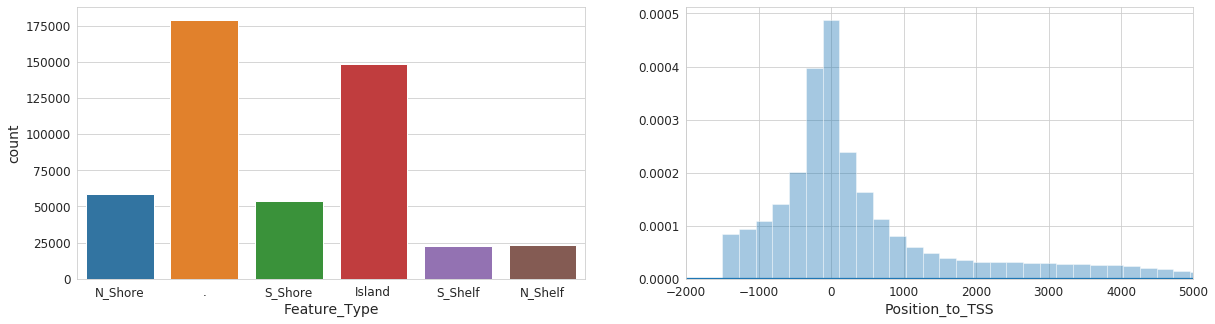

In [38]:
metameth = study.data['DNA Methylation']['meta450']

first_tss_non_null = metameth[metameth['Position_to_TSS'] != '.']['Position_to_TSS'].apply(lambda x: int(x.split(';')[0]))

fig, axs = plt.subplots(ncols=2)

sns.countplot(metameth['Feature_Type'], ax = axs[0])
sns.distplot(first_tss_non_null, bins = 10000, ax = axs[1])
axs[1].set_xlim(-2000,5000)
plt.show()

(The feature type labelled as "." is essentially denoting an unkown/ambiguous feature assigned to that loci)

### What do the DNA methylation and expression values look like along the gene profile?
Position to start site is normalized such that the TSS is ~0.3 here

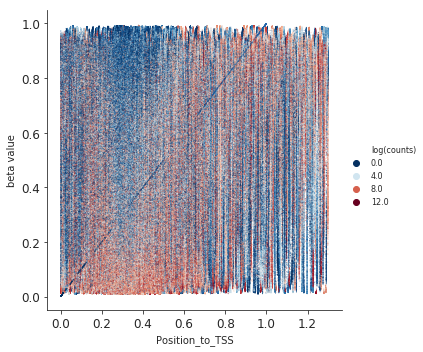

In [182]:
df = study.frame.sort_index(level = [0,1])
df.index.names = ['case_id', 'Gene_Symbol']
# Add ages
df_ = pd.merge(df, study.metadata.drop_duplicates(subset = 'case_id', keep = 'first').set_index('case_id')['age'].reset_index(), on = 'case_id').drop(['case_id'], axis = 1)
df = pd.DataFrame(df_.values, index = df.index, columns = df.columns.append(pd.MultiIndex.from_tuples([('age', 'age', 'age')])))

# Rearrange to have `position_to_transcription_start_site`, `methylation_beta_value`, and `expression`
pos_beta_exp = df.xs('DNA Methylation', axis = 1).swaplevel(0,1, axis = 1).stack(dropna = False)
pos_beta_exp = pos_beta_exp.join(df.xs(['RNA', 'age'], axis = 1))
pos_beta_exp.columns = ['Composite Element REF','Position_to_TSS','beta value', 'log(counts)', 'age']
pos_beta_exp.age = pos_beta_exp.age.astype(float)
pos_beta_exp_sort = pos_beta_exp.sort_values(by = 'log(counts)')

# Plot
sns.relplot(x = 'Position_to_TSS',
                y = 'beta value',
                hue = 'log(counts)',
                s = .1,
                marker = '.',
                edgecolor = None,
                data = pos_beta_exp,
                palette = 'RdBu_r')
plt.show()

So we can see that genes that are 'on' are typically hypomethylated (low $\beta$ value) near the TSS (\~0.3) and hypermethylated in the gene body (\~0.6-1).

Similarly, genes that are 'off' are typically hypermethylated (high $\beta$ value) near the TSS (\~0.3) and hypomethylated in the gene body (\~0.6-1).

#### DNA promoter methylation correlation with gene expression

/home/chaxor/.local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


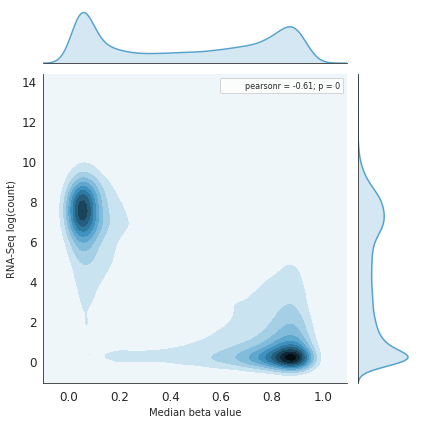

In [249]:
from scipy.stats import pearsonr

meanmeth = df.loc[:, ('DNA Methylation', slice(None), 'beta value')].mean(axis = 1)
medianmeth = df.loc[:, ('DNA Methylation', slice(None), 'beta value')].median(axis = 1)

mean_log_plot_df = pd.DataFrame({'Mean beta value': meanmeth.values,
                                'RNA-Seq log(count)': y.squeeze()})

median_log_plot_df = pd.DataFrame({'Median beta value': medianmeth.values,
                                'RNA-Seq log(count)': y.squeeze()})

ax = sns.jointplot(x = median_log_plot_df['Median beta value'][::20],
            y = median_log_plot_df['RNA-Seq log(count)'][::20],
            kind = 'kde',
            stat_func = pearsonr)

### Predicting expression from DNA methylation with a simple linear regression

/home/chaxor/.local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(0.5,0.98,'Linear Regression Expression Prediction from Median Methylation')

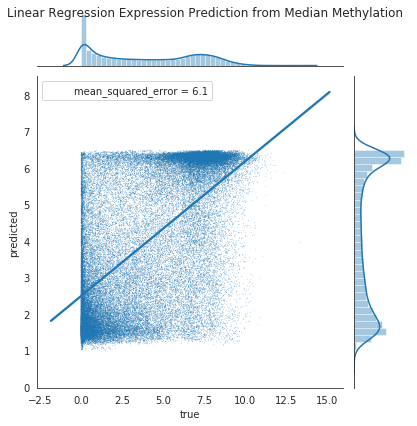

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression(fit_intercept = True, normalize = False, n_jobs = None)
lr.fit(X = median_log_plot_df['Median beta value'].values.reshape(-1,1),
       y = median_log_plot_df['RNA-Seq log(count)'].values)
lr.coef_
y_hat = lr.predict(median_log_plot_df['Median beta value'].values.reshape(-1,1))

lr_predicts = pd.DataFrame({'true':mean_log_plot_df['RNA-Seq log(count)'].values,
                            'predicted':y_hat})

ax = sns.jointplot(x = 'true',
            y = 'predicted',
            data = lr_predicts.iloc[::20],
           scatter_kws = {'s':0.01},
             kind = 'reg',
             stat_func = mean_squared_error)
ax.fig.suptitle('Linear Regression Expression Prediction from Median Methylation')

### **Long-Short Term Memory Recurrent Nerual Network** (LSTM) to predict expression with DNA methylation
#### First, make tensors for keras

In [246]:
null_value = 0

features = ['Position_to_TSS', 'beta value']

normalize_position = True
if normalize_position:
    pos_max = df.loc[:, ('DNA Methylation', slice(None), 'Position_to_TSS')].max(axis = 1).max()
    df.loc[:, ('DNA Methylation', slice(None), 'Position_to_TSS')] = df.loc[:, ('DNA Methylation', slice(None), 'Position_to_TSS')]/pos_max

meth = df.loc[:, ('DNA Methylation', slice(None), features)]

X = meth.fillna(null_value).values.reshape(len(df), -1, len(features))

rna_type = 'log(counts)'
expression = df.loc[:, ('RNA', slice(None), rna_type)]
y = expression.values

train_num = int(len(X)*0.6)
dev_num = int(len(X)*0.85)


train_X = X[:train_num]
dev_X = X[train_num:dev_num]
test_X = X[dev_num:]

train_y = y[:train_num]
dev_y = y[train_num:dev_num]
test_y = y[dev_num:]

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, LSTM, Dense, Masking
from keras.models import Model
from keras.optimizers import Adam

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

import tensorflow as tf
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)


inputs = Input(shape = (train_X.shape[1:]))
mask = Masking(mask_value = null_value, input_shape = (train_X.shape[1:]))(inputs)
lstm1 = LSTM(32, return_sequences = False)(mask)
out = Dense(1, activation = 'relu')(lstm1)

model = Model(inputs = inputs, outputs = out)

model.compile(loss = 'mse', optimizer = 'rmsprop')

### Positions
The following plot displays the positions of each loci along several DNA methylation profiles.
Each sequence is aligned along the verticle axis, where the loci existing within that gene are enumerated along the horizontal axis.  The hue intensity denotes the placement along the range of "Position to TSS" values as a value between 0 (starting/lowest value we chose for position to TSS) and 1 (ending/highest value we chose for position to TSS)

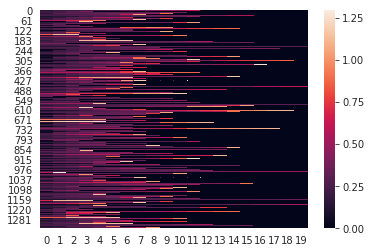

In [90]:
sns.heatmap(X[::1000,:,0])

### $\beta$ values
Similar to the "Positions" plot, the following plot displays the $\beta$ values of each loci along several DNA methylation profiles.
Each sequence is aligned along the verticle axis, where the loci existing within that gene are enumerated along the horizontal axis.  The hue intensity denotes the actual $\beta$ value for that corresponding loci

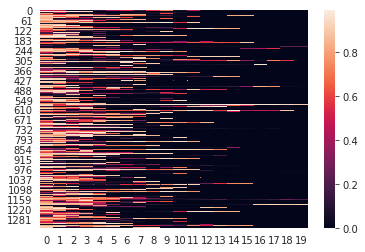

In [91]:
sns.heatmap(X[::1000,:,1])

In [266]:
model.fit(train_X, train_y, epochs = 4, batch_size = 1024*12, validation_data = (dev_X, dev_y), shuffle = True)

Train on 767125 samples, validate on 319636 samples
Epoch 1/4
767125/767125 [==============================] - 5s 6us/step - loss: 4.4736 - val_loss: 4.4825
Epoch 2/4
767125/767125 [==============================] - 5s 6us/step - loss: 4.4655 - val_loss: 4.5024
Epoch 3/4
767125/767125 [==============================] - 5s 6us/step - loss: 4.4582 - val_loss: 4.4900
Epoch 4/4
767125/767125 [==============================] - 5s 6us/step - loss: 4.4484 - val_loss: 4.4471


/home/chaxor/.local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(0.5,0.98,'LSTM Model\nExpression Prediction from Methylation Sequence')

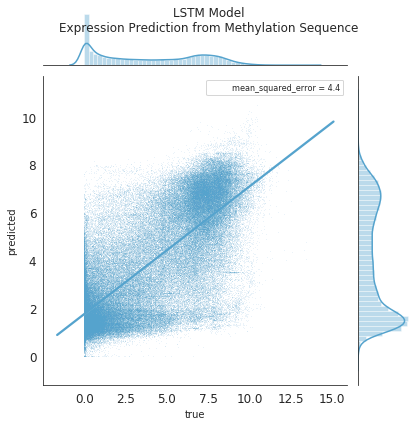

In [269]:
from sklearn.metrics import mean_squared_error

y_true = test_y
y_pred = model.predict(test_X)

lstm_predicts = pd.DataFrame({'true':y_true.squeeze(),
                              'predicted':y_pred.flatten()})

ax = sns.jointplot(x = 'true',
                   y = 'predicted',
                   data = lstm_predicts,
                   scatter_kws = {'s':0.1},
                   kind = 'reg',
                   stat_func = mean_squared_error)

ax.fig.suptitle('LSTM Model\nExpression Prediction from Methylation Sequence')

---

## **Example 3**: 
## **DNA Methylation Clock**

Many researchers may be interested in aging research and the observation that DNA methylation can be used to predict the age of patients.  The typical model used to show this is an Elastic Net model. We present the following code as an example of how simple `autoGDC` makes the process of creating a regression model on DNA methylation or transcription data.

#### Data filtering and setup

In [ ]:
# Filter to only relevant sites for aging
age_mi = pd.read_csv('autoGDC/data/age_methylation_site_mutual_information.csv', index_col = 0).iloc[:,0]
use_meth_features = age_mi[age_mi.quantile(q = 0.85) < age_mi].index.tolist()

# filter down the study files
m = study.metadata
m = m[(m['age']>25) & m['age']<100]
m = m[m.file_name.apply(lambda x: 'HumanMethylation450' in x)]
m = m.loc[m.age.dropna().index]

# save them back to the metadata
study.metadata = m

# Subset data
df = study.data["DNA Methylation"]["450"].reindex(index=use_meth_features, columns=m.index).dropna()

#### Training the Elastic Net Model

In [73]:
from sklearn.linear_model import ElasticNetCV

Enet = ElasticNetCV()
train_X = df.T.sample(frac=.75)
train_y = study.metadata.reindex(train_X.index).age
test_X = df.T.loc[~df.T.index.isin(train_X.index.tolist())]
test_y = study.metadata.reindex(test_X.index).age
net = Enet.fit(train_X, train_y)
net


/home/chaxor/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
       n_jobs=None, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

#### Prediction

In [76]:
from statsmodels import robust
p = net.predict(test_X)
t = test_y

robust.mad(p, t)

0.0646830877314689

We can see that for the model we trained in this small example, our mean absolute deviation (MAD) on our test set is only 0.06 years.

This model training can easily be used as the first step in studying common factors within the DNA methylation loci which are associated with age.

---